<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), f'Weight_Epoch{epoch+1}.pth')
    scheduler.step()


Epoch 1: Loss: 1.1985, Train Accuracy: 58.59%
Test Accuracy: 68.29%
Confusion Matrix (Epoch 1):
[[638  29 150  18   9   7  18   8  98  25]
 [ 16 869  28   6   0  11  15   6  24  25]
 [ 40   1 690  30  93  55  69  17   3   2]
 [ 12   8 108 505  73 110 150  24   9   1]
 [ 24   3  96  41 677  12  79  59   8   1]
 [  3   1  89 205  72 568  35  25   2   0]
 [  3   1  99  52  54   7 782   1   1   0]
 [ 16   4  70  60  82  70  21 671   0   6]
 [ 49  55  25  23   7   6  22   4 788  21]
 [ 24 201  15  24   2  28  21  23  21 641]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.9448, Train Accuracy: 67.72%
Test Accuracy: 74.45%
Confusion Matrix (Epoch 2):
[[847  17  39  14  20   3   3  10   7  40]
 [ 15 888   1   5   0   1   2   4   1  83]
 [ 75   4 663  25  71  46  56  44   0  16]
 [ 38   9  47 569  53 141  50  74   3  16]
 [ 14   2  46  27 681  14  45 164   5   2]
 [ 12   3  50 121  31 655  13 105   2   8]
 [  9   9  53  93  24  12 774  19   3   4]
 [ 29   2  11  16  15  17   9 885   2  14]
 [188  93  19   7  11   1   2   7 632  40]
 [ 37  84   3  11   1   3   1   5   4 851]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 1.0807, Train Accuracy: 64.54%
Test Accuracy: 66.96%
Confusion Matrix (Epoch 3):
[[708  35 120  22  14   8  10  19  27  37]
 [ 13 853   9   8   1  13  18   9   6  70]
 [ 53   1 551  28 118 131  61  47   5   5]
 [ 15   3  89 371  70 301  68  68   5  10]
 [ 30   4  66  31 624  51  48 135   9   2]
 [  6   2  57  57  47 738  14  73   4   2]
 [  3   5  92  41  87  34 719  10   7   2]
 [  8   5  36  13  34  99   7 778   1  19]
 [176 101  28   5   9  13   2  10 612  44]
 [ 37 138   9   6   6  14  10  24  14 742]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.8923, Train Accuracy: 69.28%
Test Accuracy: 77.25%
Confusion Matrix (Epoch 4):
[[862   6  50  13   5   1   2   8  24  29]
 [ 21 810   4   3   1   4   4   4  21 128]
 [ 74   0 718  31  57  32  45  37   2   4]
 [ 32   3  70 604  48 112  59  49  10  13]
 [ 37   1  70  33 700  17  32 103   6   1]
 [ 14   0  63 155  34 652   8  64   6   4]
 [ 13   2  62  46  24  15 816  13   4   5]
 [ 37   2  18  44  18  25   1 846   2   7]
 [115  12  10   3   0   2   3   3 835  17]
 [ 49  18   7   5   0   3   0   8  28 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.7343, Train Accuracy: 74.61%
Test Accuracy: 79.48%
Confusion Matrix (Epoch 5):
[[814   8 104   8  21   4   5   9  12  15]
 [ 30 905   1   3   1   1   4   3  23  29]
 [ 23   0 796  23  66  14  41  29   4   4]
 [ 17   5  89 615  50  86  64  63   5   6]
 [  5   1  43  26 838  14  33  38   2   0]
 [ 13   0  95 157  38 594  29  67   4   3]
 [  3   3  48  31  25   9 871   8   2   0]
 [ 16   4  17  30  43  21   4 858   1   6]
 [108  12  11   9   6   0   4   6 834  10]
 [ 59  75   6   4   1   2   6   7  17 823]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.7113, Train Accuracy: 75.33%
Test Accuracy: 61.82%
Confusion Matrix (Epoch 6):
[[865  30  12   6   7   0   3  36  20  21]
 [ 45 866   6   5   1   4   4  25   7  37]
 [188   6 527  31  41  34  44 117   4   8]
 [ 92  15  85 369  44 165  49 165  12   4]
 [ 48   3 143  25 494  19 102 162   3   1]
 [ 41  11  74  65  41 412  17 330   5   4]
 [ 53  10 111  78  11  14 656  58   2   7]
 [ 31   2  17  19  22   9   4 895   0   1]
 [306  46  15   6  17   9   4  32 510  55]
 [ 72 235   5   7   5   6   2  70  10 588]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.7541, Train Accuracy: 74.06%
Test Accuracy: 79.58%
Confusion Matrix (Epoch 7):
[[896  16  11   4   5   5   3   6  41  13]
 [ 20 913   3   2   0   8   3   3  12  36]
 [ 87   2 716  14  67  57  25  22   6   4]
 [ 32   3  53 463  45 282  42  58  11  11]
 [ 32   1  32  35 795  40  31  27   7   0]
 [ 15   0  35  51  29 817   8  40   5   0]
 [  5   4  53  39  24  51 803  10   9   2]
 [ 29   3  12   7  43  81   1 815   2   7]
 [ 63  16   5   4   0   4   0   6 895   7]
 [ 32  59   6   6   1  12   3   5  31 845]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.6598, Train Accuracy: 77.10%
Test Accuracy: 80.86%
Confusion Matrix (Epoch 8):
[[833  13  39  12   9   4  11  10  24  45]
 [  7 839   2   1   0   3  14   1  15 118]
 [ 31   2 751  35  33  73  57  10   5   3]
 [ 15   1  39 661  27 124  89  21  10  13]
 [  7   1  62  52 732  24  90  24   8   0]
 [  5   0  18 140  30 739  42  20   5   1]
 [  2   1  28  19   5   7 929   4   4   1]
 [ 10   0  15  43  45  58   6 816   0   7]
 [ 74  14   9   4   3   1   3   3 864  25]
 [ 15  18   1   6   2   5   9   8  14 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.6252, Train Accuracy: 78.30%
Test Accuracy: 82.29%
Confusion Matrix (Epoch 9):
[[875  14  17   8   8   2   4  16  39  17]
 [ 15 940   1   3   1   2   6   1   3  28]
 [ 54   0 672  44  79  48  73  21   8   1]
 [ 18   1  23 717  48 107  47  27  11   1]
 [  7   1  19  41 826  18  52  31   5   0]
 [  9   0  13 168  39 718  22  27   2   2]
 [ 10   1  19  64  10  10 877   4   4   1]
 [  8   1   4  33  31  37   5 877   1   3]
 [ 43  26   1  12   1   0   2   5 892  18]
 [ 22  91   4  18   2   2   3   7  16 835]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.5953, Train Accuracy: 79.33%
Test Accuracy: 81.10%
Confusion Matrix (Epoch 10):
[[781  22  13  11  17  10   9   4  99  34]
 [  2 923   1   3   0   4   7   0  41  19]
 [ 48   0 735  28  57  73  36   9  12   2]
 [ 14   5  39 556  36 247  75  10  11   7]
 [  2   1  29  25 807  56  34  33  12   1]
 [  3   1  13  69  23 845  17  17  10   2]
 [  3   3  31  13  19  28 895   4   4   0]
 [  5   2   8  36  40 105   3 787   9   5]
 [ 12  13   2   6   5   4   2   2 953   1]
 [  7  95   2   5   0   6   3   3  51 828]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.5008, Train Accuracy: 82.65%
Test Accuracy: 85.77%
Confusion Matrix (Epoch 11):
[[885  10  21   6   9   0   5   2  40  22]
 [  6 936   1   3   1   1   3   0  13  36]
 [ 37   0 788  24  50  47  33  16   4   1]
 [ 16   4  34 671  37 159  41  21   8   9]
 [  2   1  28  27 851  19  25  40   7   0]
 [  6   0  14 100  22 823   8  23   3   1]
 [  4   2  22  31  13   9 909   6   4   0]
 [ 10   0  10  17  24  47   1 886   1   4]
 [ 32  14   1   6   3   3   1   2 928  10]
 [ 18  47   4   5   0   4   3   3  16 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.4586, Train Accuracy: 84.05%
Test Accuracy: 86.53%
Confusion Matrix (Epoch 12):
[[891  11  25   4   8   0   3   5  34  19]
 [  7 935   0   3   1   1   3   0   9  41]
 [ 28   0 840  21  33  30  27  17   3   1]
 [ 15   3  53 709  39 106  36  24   6   9]
 [  3   1  42  23 864  13  26  24   4   0]
 [  7   0  28 123  26 781  13  21   0   1]
 [  4   2  30  26  13   6 912   4   2   1]
 [  8   0   7  19  31  34   2 895   0   4]
 [ 40  13   1   9   3   1   2   3 919   9]
 [ 18  41   4   9   0   1   3   5  12 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.4447, Train Accuracy: 84.56%
Test Accuracy: 86.49%
Confusion Matrix (Epoch 13):
[[908  11  13   6   7   2   2   7  30  14]
 [  8 943   0   3   0   1   2   0   7  36]
 [ 44   0 770  34  56  43  33  16   3   1]
 [ 16   4  26 729  43 117  33  20   4   8]
 [  2   1  18  24 872  18  26  37   2   0]
 [  8   0  12 132  22 789  11  23   1   2]
 [  8   2  12  31  12   5 921   6   2   1]
 [  8   2   6  25  18  33   2 903   0   3]
 [ 45  15   1   9   5   2   0   3 909  11]
 [ 20  42   4   8   0   2   2   6  11 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.4320, Train Accuracy: 84.97%
Test Accuracy: 86.95%
Confusion Matrix (Epoch 14):
[[906  11  16   7   7   1   2   3  29  18]
 [  8 939   1   3   1   2   2   0   8  36]
 [ 38   0 837  19  39  26  22  16   2   1]
 [ 17   2  44 698  42 131  34  21   4   7]
 [  2   1  42  20 866  17  27  22   3   0]
 [  8   0  20 111  21 804  10  23   2   1]
 [  6   1  26  25  12   9 912   6   2   1]
 [  9   1   8  19  28  28   1 900   0   6]
 [ 43  11   1   6   2   3   1   2 922   9]
 [ 18  41   4   6   0   1   3   4  12 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.4201, Train Accuracy: 85.24%
Test Accuracy: 87.02%
Confusion Matrix (Epoch 15):
[[896  10  23   8   8   2   1   5  32  15]
 [  9 935   2   4   0   1   3   0   9  37]
 [ 26   0 832  30  49  26  23  11   2   1]
 [ 16   2  40 707  41 131  35  18   5   5]
 [  1   1  26  23 882  19  27  18   3   0]
 [  6   0  15 115  24 810  12  16   2   0]
 [  6   0  22  28  13   5 919   5   2   0]
 [  6   1   8  24  30  45   2 878   1   5]
 [ 37  13   1   9   3   1   1   2 925   8]
 [ 18  31   4   6   0   2   3   5  13 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.4100, Train Accuracy: 85.62%
Test Accuracy: 87.24%
Confusion Matrix (Epoch 16):
[[890  12  23   5   7   0   1   8  41  13]
 [  8 935   1   2   1   1   3   1   7  41]
 [ 27   1 843  18  43  25  24  17   1   1]
 [ 14   4  42 703  44 121  37  22   6   7]
 [  2   1  32  26 873  17  22  22   5   0]
 [  5   0  21 110  24 801   9  26   2   2]
 [  4   1  23  30  12   7 913   6   3   1]
 [  4   0   7  16  20  25   1 921   1   5]
 [ 32  12   2   7   2   1   2   1 932   9]
 [ 20  34   4   4   0   2   4   5  14 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.4026, Train Accuracy: 85.88%
Test Accuracy: 87.12%
Confusion Matrix (Epoch 17):
[[902   9  18  10   7   0   2   5  32  15]
 [  6 941   2   4   0   1   3   0  12  31]
 [ 30   0 859  21  37  19  21  10   2   1]
 [ 15   2  47 723  34 122  30  17   5   5]
 [  1   1  40  35 858  20  26  17   2   0]
 [  6   0  23 118  18 805  11  17   1   1]
 [  5   1  28  34   8   7 913   2   1   1]
 [  5   2  12  23  20  40   4 889   1   4]
 [ 38  10   1  11   3   1   2   2 924   8]
 [ 24  40   4   7   0   3   4   5  15 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.4008, Train Accuracy: 86.03%
Test Accuracy: 87.43%
Confusion Matrix (Epoch 18):
[[912   8  13   7   8   2   1   3  33  13]
 [  7 946   1   4   1   1   5   0   8  27]
 [ 36   0 832  20  51  25  20  13   2   1]
 [ 18   2  38 728  46 109  32  17   5   5]
 [  1   1  30  20 886  15  23  20   4   0]
 [  9   0  17 121  25 792  17  18   1   0]
 [  6   1  31  24  13   5 916   2   1   1]
 [ 10   1  10  16  29  38   1 888   2   5]
 [ 33   9   1   9   2   0   1   2 937   6]
 [ 22  37   3   5   0   1   4   4  18 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.3874, Train Accuracy: 86.56%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 19):
[[910   7  15   6   8   2   3   6  27  16]
 [  8 934   1   4   1   1   3   1   8  39]
 [ 25   1 856  17  38  28  20  13   1   1]
 [ 15   2  40 692  40 147  35  19   6   4]
 [  2   1  38  23 862  19  33  19   3   0]
 [  8   0  17 101  22 822  13  17   0   0]
 [  5   2  22  30   6   4 925   4   1   1]
 [  5   1  10  15  22  38   2 902   1   4]
 [ 37  12   3   7   3   2   1   1 926   8]
 [ 21  32   4   8   0   4   2   5  12 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.3863, Train Accuracy: 86.47%
Test Accuracy: 87.67%
Confusion Matrix (Epoch 20):
[[915  10  17   9   9   1   1   4  24  10]
 [  7 954   1   3   1   1   3   0   4  26]
 [ 23   1 857  17  44  24  21  11   1   1]
 [ 12   4  51 729  41 106  32  15   6   4]
 [  3   1  26  21 896  15  19  16   3   0]
 [ 10   0  18 130  25 790  11  16   0   0]
 [  6   1  26  28  18   7 907   5   2   0]
 [ 10   2   9  16  26  28   2 904   0   3]
 [ 42  15   3  10   3   1   0   1 917   8]
 [ 22  53   4   3   0   1   3   4  12 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.3673, Train Accuracy: 87.08%
Test Accuracy: 87.68%
Confusion Matrix (Epoch 21):
[[896   9  14   9  13   2   1   5  34  17]
 [  6 944   1   3   0   1   3   0   5  37]
 [ 23   1 844  20  47  24  24  14   1   2]
 [  8   4  41 736  43 110  30  16   6   6]
 [  2   1  24  21 887  18  23  21   3   0]
 [  8   0  17 130  24 792  11  18   0   0]
 [  6   1  24  28  13   7 913   5   2   1]
 [  5   2   8  14  22  28   2 914   1   4]
 [ 34  13   3   9   4   2   1   1 924   9]
 [ 18  34   4   5   0   1   3   5  12 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.3634, Train Accuracy: 87.40%
Test Accuracy: 87.81%
Confusion Matrix (Epoch 22):
[[902  11  12   6   8   2   1   5  38  15]
 [  7 948   1   3   0   1   2   0   6  32]
 [ 28   1 847  18  44  22  24  13   1   2]
 [ 15   3  39 735  40 109  29  16   7   7]
 [  2   1  26  22 882  18  25  21   3   0]
 [  8   0  18 131  25 789  12  14   2   1]
 [  6   1  21  31   9   6 918   4   2   2]
 [  5   2   8  14  21  28   2 913   2   5]
 [ 31  10   2   8   3   2   0   1 935   8]
 [ 18  40   4   4   0   1   2   4  15 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.3585, Train Accuracy: 87.36%
Test Accuracy: 87.90%
Confusion Matrix (Epoch 23):
[[911   7  13  10   7   2   1   4  31  14]
 [  7 945   1   3   1   1   3   0   8  31]
 [ 27   1 843  19  44  26  24  13   1   2]
 [ 13   3  38 737  39 116  27  17   6   4]
 [  4   1  25  22 884  18  23  20   3   0]
 [  7   0  14 124  24 801  11  16   2   1]
 [  6   0  20  32  10   6 920   4   2   0]
 [  5   2   9  15  21  34   2 908   1   3]
 [ 35  10   2   8   3   2   1   2 929   8]
 [ 19  37   3   7   0   1   2   5  14 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.3586, Train Accuracy: 87.51%
Test Accuracy: 87.67%
Confusion Matrix (Epoch 24):
[[907   9  12   8   7   2   1   5  34  15]
 [  8 940   1   3   0   1   2   0  10  35]
 [ 32   1 837  19  45  25  23  15   1   2]
 [ 17   3  35 735  39 108  31  17   7   8]
 [  4   1  25  25 881  17  22  22   3   0]
 [  8   0  15 135  25 786  11  17   2   1]
 [  6   1  20  30  11   6 918   4   2   2]
 [  4   2   7  16  21  24   2 918   2   4]
 [ 34  10   1   8   3   2   0   2 932   8]
 [ 19  34   3   5   0   1   2   4  19 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.3650, Train Accuracy: 87.05%
Test Accuracy: 87.60%
Confusion Matrix (Epoch 25):
[[913   8  10   6   6   2   2   5  32  16]
 [  7 937   1   3   0   1   3   0  10  38]
 [ 33   1 840  22  38  25  24  14   1   2]
 [ 14   3  35 733  35 118  34  16   7   5]
 [  3   1  29  31 865  20  29  19   3   0]
 [  5   0  18 130  21 794  11  17   2   2]
 [  7   0  20  29   8   6 923   4   2   1]
 [  4   2   7  15  19  35   2 910   2   4]
 [ 35  11   1   9   2   1   1   2 929   9]
 [ 19  33   3   5   0   2   3   3  16 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.3560, Train Accuracy: 87.40%
Test Accuracy: 87.88%
Confusion Matrix (Epoch 26):
[[909   9  12   7   9   2   1   5  30  16]
 [  8 941   1   3   0   1   2   0   5  39]
 [ 30   1 832  21  48  24  25  16   1   2]
 [ 14   4  35 728  43 115  31  17   6   7]
 [  2   1  17  23 894  18  23  19   3   0]
 [  5   0  15 130  23 793  11  19   2   2]
 [  6   0  19  23  12   6 927   4   2   1]
 [  5   2   7  14  22  26   2 917   1   4]
 [ 37  11   1   8   3   1   0   2 926  11]
 [ 19  34   3   4   0   2   1   3  13 921]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.3550, Train Accuracy: 87.67%
Test Accuracy: 87.94%
Confusion Matrix (Epoch 27):
[[899   8  18   6  10   1   2   5  35  16]
 [  7 942   1   3   0   1   3   0   9  34]
 [ 24   1 865  21  39  17  19  12   1   1]
 [ 12   3  40 732  41 116  26  17   7   6]
 [  2   1  32  23 885  16  23  16   2   0]
 [  5   0  22 129  21 793  12  15   2   1]
 [  5   0  28  27  10   6 919   2   2   1]
 [  3   2  10  16  23  34   2 905   2   3]
 [ 29   9   2   8   3   2   1   1 937   8]
 [ 18  34   4   3   0   2   4   3  15 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.3507, Train Accuracy: 87.92%
Test Accuracy: 87.74%
Confusion Matrix (Epoch 28):
[[911   8  13   7   7   2   2   4  32  14]
 [  9 946   1   2   0   1   2   0   7  32]
 [ 30   1 860  19  35  22  18  12   1   2]
 [ 17   4  37 731  36 120  28  16   5   6]
 [  3   1  33  30 867  20  23  20   3   0]
 [  8   0  24 127  19 796   8  15   2   1]
 [  8   0  25  30  10   6 914   4   2   1]
 [  6   2   9  15  22  35   2 903   2   4]
 [ 33  11   1   8   3   2   1   1 932   8]
 [ 20  38   3   5   0   1   1   3  15 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.3508, Train Accuracy: 87.72%
Test Accuracy: 87.85%
Confusion Matrix (Epoch 29):
[[906   6  14   8   9   2   2   5  33  15]
 [  8 935   1   3   0   1   2   0  10  40]
 [ 28   1 844  18  46  25  20  15   1   2]
 [ 13   3  35 737  41 116  28  16   5   6]
 [  2   1  25  23 891  15  22  18   3   0]
 [  6   0  17 126  23 799  11  15   2   1]
 [  8   0  23  27  12   6 917   4   2   1]
 [  3   1   7  17  24  36   2 903   2   5]
 [ 33  10   2   8   3   2   1   1 930  10]
 [ 19  29   3   5   0   1   2   4  14 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.3497, Train Accuracy: 87.72%
Test Accuracy: 87.91%
Confusion Matrix (Epoch 30):
[[907   7  14   8  10   2   1   5  32  14]
 [  7 939   1   3   0   1   3   0  11  35]
 [ 24   1 848  21  44  24  20  15   1   2]
 [ 12   3  34 737  40 119  26  17   6   6]
 [  2   1  25  28 880  18  22  21   3   0]
 [  5   0  18 130  19 798  10  17   2   1]
 [  6   0  24  30  10   6 917   4   2   1]
 [  3   2   7  16  18  32   2 914   2   4]
 [ 30  10   2   9   2   2   1   1 933  10]
 [ 18  32   4   5   0   2   2   3  16 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.3459, Train Accuracy: 87.91%
Test Accuracy: 87.95%
Confusion Matrix (Epoch 31):
[[909   8  13   7  10   2   2   5  30  14]
 [  8 947   1   4   0   1   2   0   5  32]
 [ 29   1 851  21  37  24  20  14   1   2]
 [ 13   4  35 749  37 112  25  15   4   6]
 [  3   1  30  31 872  19  22  19   3   0]
 [  5   0  20 131  19 798  10  15   2   0]
 [  7   0  24  32   8   6 916   4   2   1]
 [  4   2   7  17  20  34   2 908   2   4]
 [ 33  11   1   9   2   2   1   1 930  10]
 [ 19  38   3   6   0   1   2   3  13 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.3470, Train Accuracy: 87.77%
Test Accuracy: 87.85%
Confusion Matrix (Epoch 32):
[[909   7  13   7   9   2   2   5  32  14]
 [  7 946   1   3   0   1   3   0   7  32]
 [ 27   1 858  20  37  22  20  13   1   1]
 [ 15   3  36 739  39 112  32  13   5   6]
 [  3   1  30  29 875  16  26  17   3   0]
 [  6   0  22 135  19 788  12  15   2   1]
 [  7   0  25  29   8   6 920   2   2   1]
 [  4   2   8  18  22  34   2 904   2   4]
 [ 31  10   2  10   3   1   1   1 931  10]
 [ 18  35   4   6   0   1   4   3  14 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.3474, Train Accuracy: 87.97%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 33):
[[907   9  14   5  11   2   2   5  31  14]
 [  8 941   1   3   0   1   2   0   9  35]
 [ 25   1 857  17  39  24  18  15   1   3]
 [ 13   3  38 730  42 113  29  18   7   7]
 [  2   1  29  24 884  16  22  19   3   0]
 [  5   0  22 125  20 795  10  19   2   2]
 [  7   0  26  29  10   6 915   4   2   1]
 [  4   1   8  15  22  27   2 914   2   5]
 [ 32  10   1   8   3   1   1   1 932  11]
 [ 18  33   4   4   0   2   1   4  13 921]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.3466, Train Accuracy: 87.84%
Test Accuracy: 87.97%
Confusion Matrix (Epoch 34):
[[906  11  12   6  10   2   2   5  32  14]
 [  8 949   1   3   0   1   2   0   5  31]
 [ 28   1 850  17  41  24  21  15   1   2]
 [ 12   3  36 734  39 117  29  16   7   7]
 [  3   1  29  27 880  16  23  18   3   0]
 [  5   0  21 126  19 801  10  15   2   1]
 [  6   0  24  29   9   6 919   4   2   1]
 [  4   2   7  16  21  31   2 911   2   4]
 [ 32  11   1   8   3   2   0   1 933   9]
 [ 19  38   3   4   0   2   1   3  16 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.3470, Train Accuracy: 87.74%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 35):
[[905  11  13   5  11   2   2   5  31  15]
 [  8 948   1   3   0   1   2   0   5  32]
 [ 24   1 855  18  43  23  19  14   1   2]
 [ 14   4  36 725  42 121  28  16   6   8]
 [  3   1  26  24 885  17  21  20   3   0]
 [  5   0  20 122  19 801  10  19   2   2]
 [  5   2  25  27  13   6 915   4   2   1]
 [  3   2   8  14  20  30   2 915   2   4]
 [ 31  12   2   8   3   2   0   1 931  10]
 [ 18  39   4   5   0   1   1   2  14 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.3482, Train Accuracy: 87.81%
Test Accuracy: 87.89%
Confusion Matrix (Epoch 36):
[[915   8  13   5   9   1   2   4  29  14]
 [  9 947   1   2   0   1   2   0   6  32]
 [ 29   1 850  17  40  25  22  13   1   2]
 [ 16   3  38 720  41 121  32  15   7   7]
 [  3   1  27  24 885  17  23  17   3   0]
 [  6   0  21 121  20 803  11  15   2   1]
 [  5   0  24  27  10   6 921   4   2   1]
 [  6   2   7  14  21  34   2 908   2   4]
 [ 36  11   1   8   3   2   1   1 927  10]
 [ 20  37   3   4   0   2   4   3  14 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.3463, Train Accuracy: 87.89%
Test Accuracy: 87.92%
Confusion Matrix (Epoch 37):
[[910   8  12   6  10   2   2   5  31  14]
 [  8 943   1   3   0   1   2   0  10  32]
 [ 28   1 845  18  45  25  20  15   1   2]
 [ 14   3  35 731  42 114  30  17   7   7]
 [  3   1  26  25 885  16  23  19   2   0]
 [  5   0  20 128  20 796  10  17   2   2]
 [  8   0  23  28  10   6 918   4   2   1]
 [  4   2   7  17  21  27   2 914   2   4]
 [ 32  10   1   8   3   1   1   1 933  10]
 [ 19  35   3   6   0   1   2   3  14 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.3463, Train Accuracy: 87.82%
Test Accuracy: 87.93%
Confusion Matrix (Epoch 38):
[[912   6  13   6  11   1   2   5  30  14]
 [  9 938   1   2   0   1   2   0  11  36]
 [ 27   1 847  22  47  19  18  16   1   2]
 [ 15   3  38 738  43 107  24  19   6   7]
 [  2   1  26  23 894  12  20  20   2   0]
 [  6   0  23 133  20 786  11  18   2   1]
 [  8   0  27  28  14   6 910   4   2   1]
 [  5   1   8  16  23  23   2 916   2   4]
 [ 34  10   1   8   3   1   0   1 931  11]
 [ 18  32   4   5   0   1   1   4  14 921]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.3494, Train Accuracy: 87.75%
Test Accuracy: 87.89%
Confusion Matrix (Epoch 39):
[[907   9  13   6   9   1   2   5  34  14]
 [  7 943   1   3   0   1   3   0   9  33]
 [ 27   1 853  18  38  23  22  15   1   2]
 [ 16   3  37 730  38 109  35  18   7   7]
 [  4   1  28  25 878  15  27  19   3   0]
 [  5   0  22 129  19 792  12  17   2   2]
 [  7   0  23  25  10   6 922   4   2   1]
 [  5   2   7  16  22  25   2 915   2   4]
 [ 32  10   1   8   3   2   1   1 932  10]
 [ 18  34   4   5   0   1   3   4  14 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.3511, Train Accuracy: 87.80%
Test Accuracy: 87.85%
Confusion Matrix (Epoch 40):
[[913   7  13   6  11   1   2   4  29  14]
 [  8 946   1   3   1   1   2   0   7  31]
 [ 24   1 865  17  40  21  19  11   1   1]
 [ 16   4  41 721  44 118  32  12   5   7]
 [  3   1  28  23 892  14  23  14   2   0]
 [  6   0  25 126  21 793  12  14   2   1]
 [  6   0  27  28  10   6 916   4   2   1]
 [  5   2  11  16  28  36   2 895   2   3]
 [ 37  11   1   8   3   2   1   1 926  10]
 [ 18  35   4   5   0   1   3   3  13 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.3502, Train Accuracy: 87.75%
Test Accuracy: 87.93%
Confusion Matrix (Epoch 41):
[[910   6  14   6  10   1   2   5  32  14]
 [  7 942   1   3   1   1   3   0  11  31]
 [ 25   1 850  18  44  24  21  15   1   1]
 [ 13   3  36 736  43 111  29  17   6   6]
 [  3   1  26  26 886  15  23  18   2   0]
 [  5   0  20 131  21 793  11  16   2   1]
 [  6   0  24  27  11   6 919   4   2   1]
 [  4   2   8  17  22  29   2 911   2   3]
 [ 32  10   1   8   3   2   1   1 933   9]
 [ 18  34   4   5   0   2   3   5  16 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.3441, Train Accuracy: 87.82%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 42):
[[908  10  12   5  10   2   2   5  32  14]
 [  8 943   1   3   0   1   2   0   9  33]
 [ 28   1 856  17  41  22  19  13   1   2]
 [ 15   3  37 731  42 113  29  15   7   8]
 [  3   1  27  24 886  16  23  17   3   0]
 [  6   0  21 128  20 794  11  17   2   1]
 [  7   0  24  28  10   6 918   4   2   1]
 [  6   2   7  16  22  28   2 911   2   4]
 [ 33  10   1   8   3   1   0   1 932  11]
 [ 18  36   4   5   0   1   1   2  16 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.3466, Train Accuracy: 87.75%
Test Accuracy: 87.78%
Confusion Matrix (Epoch 43):
[[913   7  12   7   9   2   2   4  30  14]
 [  9 939   1   2   0   1   2   0  11  35]
 [ 30   1 845  19  42  24  21  15   1   2]
 [ 17   2  35 725  40 118  33  15   8   7]
 [  4   1  27  25 881  16  25  18   3   0]
 [  6   0  20 124  20 797  14  16   2   1]
 [  7   0  21  27  10   6 922   4   2   1]
 [  6   1   7  16  23  28   2 910   2   5]
 [ 34  10   1   8   3   2   1   1 931   9]
 [ 20  33   3   5   0   2   3   4  15 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.3505, Train Accuracy: 87.73%
Test Accuracy: 88.01%
Confusion Matrix (Epoch 44):
[[913   8  13   6   9   1   2   4  30  14]
 [  9 947   1   2   0   1   2   0   6  32]
 [ 28   1 859  17  39  21  19  13   1   2]
 [ 15   4  38 732  42 114  30  12   6   7]
 [  3   1  29  26 887  14  22  16   2   0]
 [  6   0  23 128  19 794  12  15   2   1]
 [  8   0  24  28  10   6 917   4   2   1]
 [  5   2  10  16  23  31   2 906   2   3]
 [ 35  11   1   8   3   2   1   1 928  10]
 [ 19  37   3   5   0   1   2   2  13 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.3429, Train Accuracy: 87.85%
Test Accuracy: 87.83%
Confusion Matrix (Epoch 45):
[[913   8  13   6   6   1   2   5  32  14]
 [  9 941   1   2   0   1   2   0  11  33]
 [ 30   1 862  18  33  24  17  12   1   2]
 [ 16   3  38 735  36 118  25  14   7   8]
 [  4   1  32  31 871  19  21  18   3   0]
 [  7   0  21 126  19 799  10  15   2   1]
 [  8   0  28  32   8   6 911   4   2   1]
 [  5   1   9  16  20  37   2 904   2   4]
 [ 34  11   1   9   2   2   0   1 931   9]
 [ 19  35   3   3   0   3   1   2  18 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.3464, Train Accuracy: 87.89%
Test Accuracy: 87.91%
Confusion Matrix (Epoch 46):
[[909   9  13   5  11   1   2   5  31  14]
 [  8 947   1   3   0   1   2   0   6  32]
 [ 28   1 844  17  48  24  20  15   1   2]
 [ 15   4  36 728  45 112  31  15   6   8]
 [  4   1  25  21 893  14  22  18   2   0]
 [  7   0  19 128  21 794  11  17   2   1]
 [  8   0  22  27  13   6 917   4   2   1]
 [  6   2   7  16  23  26   2 912   2   4]
 [ 32  11   1   8   3   1   0   1 932  11]
 [ 19  37   3   5   0   1   1   3  16 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.3454, Train Accuracy: 87.75%
Test Accuracy: 88.04%
Confusion Matrix (Epoch 47):
[[912   8  13   5  11   1   2   5  30  13]
 [  7 947   1   3   0   1   3   0   6  32]
 [ 27   1 857  17  38  23  21  14   1   1]
 [ 16   4  39 727  43 109  33  17   5   7]
 [  2   1  26  23 894  12  22  18   2   0]
 [  6   0  23 128  20 790  12  18   2   1]
 [  7   0  22  26  12   6 920   4   2   1]
 [  6   2   9  14  23  24   2 915   2   3]
 [ 35  11   1   9   3   1   1   1 927  11]
 [ 19  36   4   5   0   1   3   3  14 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.3474, Train Accuracy: 87.70%
Test Accuracy: 88.03%
Confusion Matrix (Epoch 48):
[[910   9  11   8  10   1   2   5  30  14]
 [  8 948   1   3   0   1   2   0   5  32]
 [ 30   1 850  20  40  23  19  14   1   2]
 [ 14   4  35 746  39 107  28  16   4   7]
 [  3   1  27  28 883  15  22  19   2   0]
 [  6   0  18 134  19 791  11  18   2   1]
 [  7   0  21  30   9   6 920   4   2   1]
 [  5   2   7  17  21  25   2 915   2   4]
 [ 37  12   1   9   3   2   1   1 924  10]
 [ 19  39   3   5   0   1   1   3  13 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.3453, Train Accuracy: 87.86%
Test Accuracy: 88.15%
Confusion Matrix (Epoch 49):
[[907   8  13   6  15   1   2   5  29  14]
 [  7 944   1   3   0   1   3   0   5  36]
 [ 24   1 846  17  48  25  21  15   1   2]
 [ 12   4  35 719  51 119  30  19   4   7]
 [  2   1  19  21 904  12  21  18   2   0]
 [  5   0  17 116  25 803  11  20   2   1]
 [  6   0  19  26  16   6 919   4   2   2]
 [  3   1   8  14  21  24   2 920   2   5]
 [ 35  11   1   8   3   1   0   1 929  11]
 [ 18  31   3   4   0   2   2   4  12 924]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.3459, Train Accuracy: 87.85%
Test Accuracy: 88.02%
Confusion Matrix (Epoch 50):
[[909   7  14   6  11   1   2   5  31  14]
 [  7 938   1   3   0   1   3   0  11  36]
 [ 25   1 850  17  45  24  20  15   1   2]
 [ 14   3  39 717  45 121  30  17   7   7]
 [  2   1  26  23 891  14  22  19   2   0]
 [  5   0  19 117  20 806  10  20   2   1]
 [  6   0  25  27  12   6 917   4   2   1]
 [  4   1   8  14  19  26   2 919   2   5]
 [ 32  10   1   8   3   1   0   1 933  11]
 [ 18  31   4   5   0   1   1   3  15 922]]


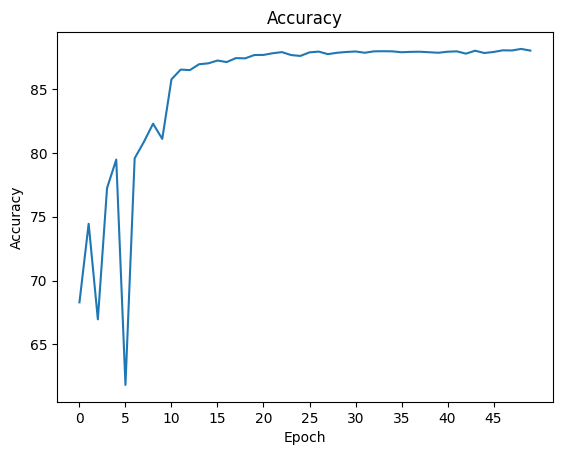

In [15]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()